# Grid indexing


Parcels supports `Fields` on any curvilinear `Grid`. For velocity `Fields` (`U`, `V` and `W`), there are some additional restrictions if the `Grid` is discretized as an Arakawa B- or Arakawa C-grid. That is because under the hood, Parcels uses a specific interpolation scheme for each of these grid types. This is described in [Section 2 of Delandmeter and Van Sebille (2019)](https://www.geosci-model-dev.net/12/3571/2019/gmd-12-3571-2019.html) and summarized below.

The summary is: 

> For Arakawa B-and C-grids, Parcels requires the locations of the _corner_ points (f-points) of the grid cells for the `dimensions` dictionary of velocity `Fields`.
 
In other words, on an Arakawa C-grid, the `[k, j, i]` node of `U` will _not_ be located at position `[k, j, i]` of `U.grid`.

## Barycentric coordinates and indexing in Parcels

### Arakawa C-grids

In a regular grid (also called an Arakawa A-grid), the velocities (`U`, `V` and `W`) and tracers (e.g. temperature) are all located in the center of each cell. But hydrodynamic model data is often supplied on staggered grids (e.g. for NEMO, POP and MITgcm), where `U`, `V` and `W` are shifted with respect to the cell centers.

To keep it simple, let's take the case of a 2D Arakawa C-grid. Zonal (`U`) velocities are located at the east and west faces of each cell and meridional (`V`) velocities at the north and south. The following diagram shows a comparison of 4x4 A- and C-grids.

![Arakawa Grid layouts](images/grid_comparison.png)

Note that different models use different indices to relate the location of the staggered velocities to the cell centers. The default C-grid indexing notation in Parcels is the same as for **NEMO** (middle panel): `U[j, i]` is located between the cell corners `[j-1, i]` and `[j, i]`, and `V[j, i]` is located between cell corners `[j, i-1]` and `[j, i]`.

Now, as you've noticed on the grid illustrated on the figure, there are 4x4 cells. The grid providing the cell corners is a 5x5 grid, but there are only 4x5 U nodes and 5x4 V nodes, since the grids are staggered. This implies that the first row of `U` data and the first column of `V` data is never used (and do not physically exist), but the `U` and `V` fields are correctly provided on a 5x5 table. If your original data are provided on a 4x5 `U` grid and a 5x4 `V` grid, you need to regrid your table to follow Parcels notation before creating a FieldSet!

**MITgcm** uses a different indexing: `U[j, i]` is located between the cell corners `[j, i]` and `[j+1, i]`, and `V[j, i]` is located between cell corners `[j, i]` and `[j, i+1]`. If you use [xmitgcm](https://xmitgcm.readthedocs.io/en/latest/) to write your data to a NetCDF file, `U` and `V` will have the same dimensions as your grid (in the above case 4x4 rather than 5x5 as in NEMO), meaning that the last column of `U` and the last row of `V` are omitted. In MITgcm, these either correspond to a solid boundary, or in the case of a periodic domain, to the first column and row respectively. In the latter case, and assuming your model domain is periodic, you can use the `FieldSet.add_periodic_halo` method to make sure particles can be correctly interpolated in the last zonal/meridional cells.

Parcels can take care of loading C-grid data for you, through the general `FieldSet.from_c_grid_dataset` method (which takes a `gridindexingtype` argument), and the model-specific methods `FieldSet.from_nemo` and `FieldSet.from_mitgcm`.

The only information that Parcels needs is the location of the 4 corners of the cell, which are called the $f$-node. Those are the ones provided by `U.grid` (and are equal to the ones in `V.grid`). Parcels does not need the exact location of the `U` and `V` nodes, because in C-grids, `U` and `V` nodes are always located in the same position relative to the $f$-node.

Importantly, the interpolation of velocities on Arakawa C-grids is done in barycentric coordinates: $\xi$, $\eta$ and $\zeta$ instead of longitude, latitude and depth. These coordinates are always between 0 and 1, measured from the corner of the grid cell. This is more accurate than simple linear interpolation on curvilinear grids.

When calling `FieldSet.from_c_grid_dataset()` or a method that is based on it like `FieldSet.from_nemo()`, Parcels automatically sets the interpolation method for the `U`, `V` and `W` `Fields` to `cgrid_velocity`. With this interpolation method, the velocity interpolation follows the description in [Section 2.1.2 of Delandmeter and Van Sebille (2019)](https://www.geosci-model-dev.net/12/3571/2019/gmd-12-3571-2019.html).

#### NEMO Example


In [1]:
from glob import glob
from os import path
import warnings

import numpy as np
import xarray as xr 

import matplotlib.pyplot as plt

import parcels

Let's see how this works. We'll use the NemoNorthSeaORCA025-N006_data data, which is on an Arakawa C-grid. If we create the `FieldSet` using the coordinates in the U, V and W files, we get an Error as seen below:


In [2]:
example_dataset_folder = parcels.download_example_dataset(
    "NemoNorthSeaORCA025-N006_data"
)
ufiles = sorted(glob(f"{example_dataset_folder}/ORCA*U.nc"))
vfiles = sorted(glob(f"{example_dataset_folder}/ORCA*V.nc"))
wfiles = sorted(glob(f"{example_dataset_folder}/ORCA*W.nc"))

filenames = {"U": ufiles, "V": vfiles, "W": wfiles}
variables = {"U": "uo", "V": "vo", "W": "wo"}
dimensions = {
    "U": {
        "lon": "nav_lon",
        "lat": "nav_lat",
        "depth": "depthu",
        "time": "time_counter",
    },
    "V": {
        "lon": "nav_lon",
        "lat": "nav_lat",
        "depth": "depthv",
        "time": "time_counter",
    },
    "W": {
        "lon": "nav_lon",
        "lat": "nav_lat",
        "depth": "depthw",
        "time": "time_counter",
    },
}

fieldset = parcels.FieldSet.from_nemo(filenames, variables, dimensions)

ValueError: On a C-grid, the dimensions of velocities should be the corners (f-points) of the cells, so the same for U and V. See also https://docs.oceanparcels.org/en/latest/examples/documentation_indexing.html

We can still load the data this way, if we use the `FieldSet.from_netcdf()` method. But because this method assumes the data is on an Arakawa-A grid, **this will mean wrong interpolation**.


In [3]:
fieldsetA = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)

Instead, we need to provide the coordinates of the $f$-points. In NEMO, these are called `glamf`, `gphif` and `depthw` (in MITgcm, these would be called `XG`, `YG` and `Zl`). The first two are in the `coordinates.nc` file, the last one is in the `W` file.


The $f$-points are the edges of the cells. Namely:

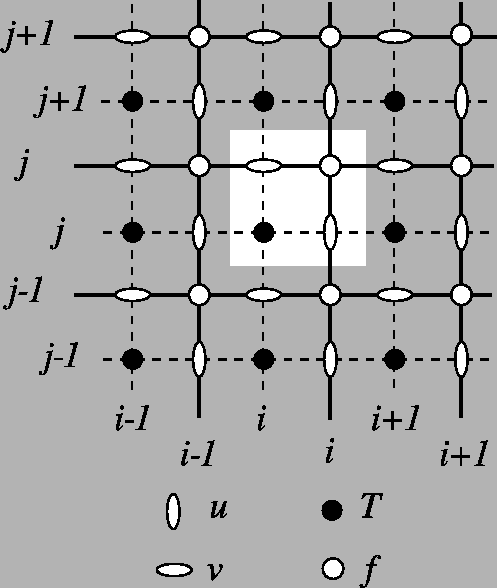

In [4]:
from IPython import display
display.Image("https://www.nemo-ocean.eu/doc/img360.png") 

For ROMS, the same applies:

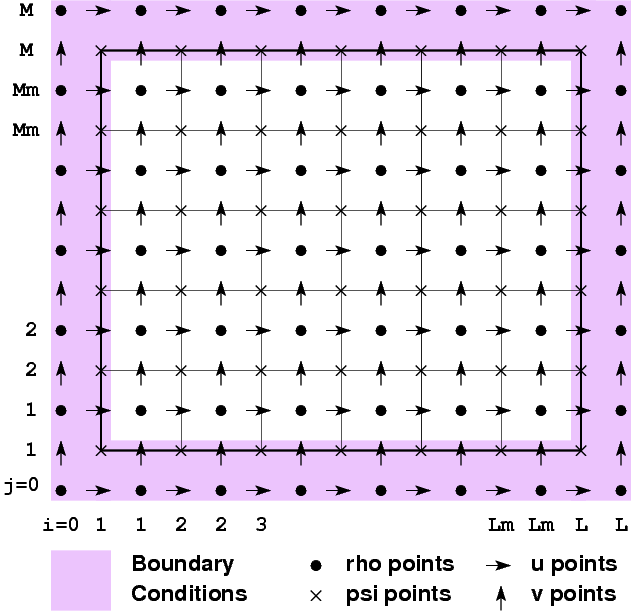

In [5]:
display.Image("https://www.myroms.org/wiki/images/0/0a/Whole_grid.png")

ROMS A-grid is interpolated in grid centers:

In [15]:
nemo = xr.open_dataset(f"{example_dataset_folder}/coordinates.nc", decode_times=False)
roms_c = xr.open_dataset("F:/ADVECTOR/metocean/roms_c-grid/test134cars_npo0.08_07e_20200101.nc")
roms_a = xr.open_dataset("F:/ADVECTOR/metocean/roms_a-grid/test134cars_npo0.08_07e_20200101.nc")
roms = xr.open_dataset("F:/ADVECTOR/metocean/grid_npo0.08_07e.nc") # lon_psi and lat_psi are present here 
print("roms_a.lat_rho", roms_a.lat_rho.values[0,0])
print("roms_c.lat_rho", roms_c.lat_rho.values[0,0])
print("roms_c.lat_u", roms_c.lat_u.values[0,0])
print("roms_c.lat_v", roms_c.lat_v.values[0,0])
print("roms_c.lat_psi", roms.lat_psi.values[0,0])

roms_a.lat_rho 16.0
roms_c.lat_rho 16.0
roms_c.lat_u 16.0
roms_c.lat_v 16.04
roms_c.lat_psi 16.04


In [ ]:
# roms = xr.open_dataset("F:/ADVECTOR/metocean/roms_c-grid/test134cars_npo0.08_07e_20200101.nc")
# lon_psi, lat_psi = np.meshgrid(roms.lon_u.values[0], roms.lat_v.values[:, 0])
# roms = roms.assign(lon_psi=(["lat", "lon"], lon_psi), lat_psi=(["lat", "lon"], lat_psi))

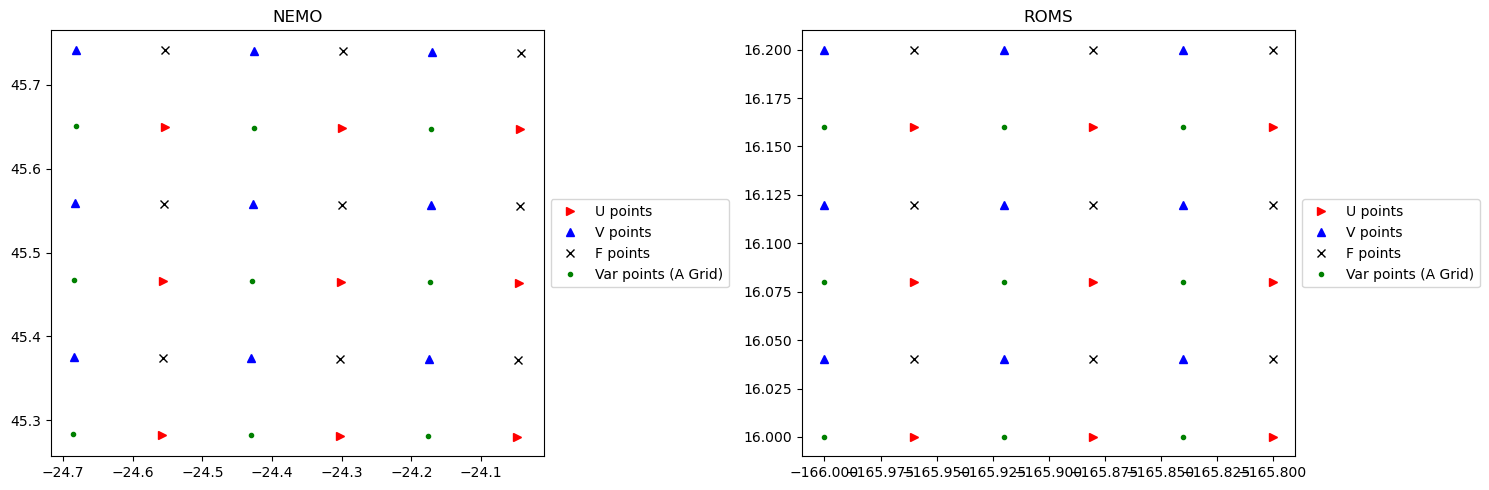

In [44]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
nind = 3

ax = axs[0]
ax1 = ax.plot(
    nemo.glamu[0, :nind, :nind],
    nemo.gphiu[0, :nind, :nind],
    ">r",
    label="U points",
)
ax2 = ax.plot(
    nemo.glamv[0, :nind, :nind],
    nemo.gphiv[0, :nind, :nind],
    "^b",
    label="V points",
)

ax3 = ax.plot(
    nemo.glamf[0, :nind, :nind],
    nemo.gphif[0, :nind, :nind],
    "xk",
    label="F points",
)

ax4 = ax.plot(
    nemo.nav_lon[:nind, :nind],
    nemo.nav_lat[:nind, :nind],
    ".g",
    label="Var points (A Grid)",
)

ax.legend(handles=[ax1[0], ax2[0], ax3[0], ax4[0]], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("NEMO")

ax = axs[1]
ax1 = ax.plot(
    roms.lon_u[:nind, :nind],
    roms.lat_u[:nind, :nind],
    ">r",
    label="U points",
)
ax2 = ax.plot(
    roms.lon_v[:nind, :nind],
    roms.lat_v[:nind, :nind],
    "^b",
    label="V points",
)

ax3 = ax.plot(
    roms.lon_psi[:nind, :nind],
    roms.lat_psi[:nind, :nind],
    "xk",
    label="F points",
)

ax4 = ax.plot(
    roms.lon_rho[:nind, :nind],
    roms.lat_rho[:nind, :nind],
    ".g",
    label="Var points (A Grid)",
)

ax.legend(handles=[ax1[0], ax2[0], ax3[0], ax4[0]], loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title("ROMS")
plt.tight_layout()
plt.show()

In [4]:
mesh_mask = f"{example_dataset_folder}/coordinates.nc"

filenames = {
    "U": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": ufiles},
    "V": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": vfiles},
    "W": {"lon": mesh_mask, "lat": mesh_mask, "depth": wfiles[0], "data": wfiles},
}

# Note that all variables need the same dimensions in a C-Grid
c_grid_dimensions = {
    "lon": "glamf",
    "lat": "gphif",
    "depth": "depthw",
    "time": "time_counter",
}
dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
    "W": c_grid_dimensions,
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", parcels.FileWarning)
    fieldsetC = parcels.FieldSet.from_nemo(filenames, variables, dimensions)

Note by the way, that we used `warnings.catch_warnings()` with `warnings.simplefilter("ignore", parcels.FileWarning)` to wrap the `FieldSet.from_nemo()` call above. This is to silence an expected warning because the time dimension in the `coordinates.nc` file can't be decoded by `xarray`.


We can plot the different grid points to see that indeed, the longitude and latitude of `fieldsetA.U` and `fieldsetA.V` are different.


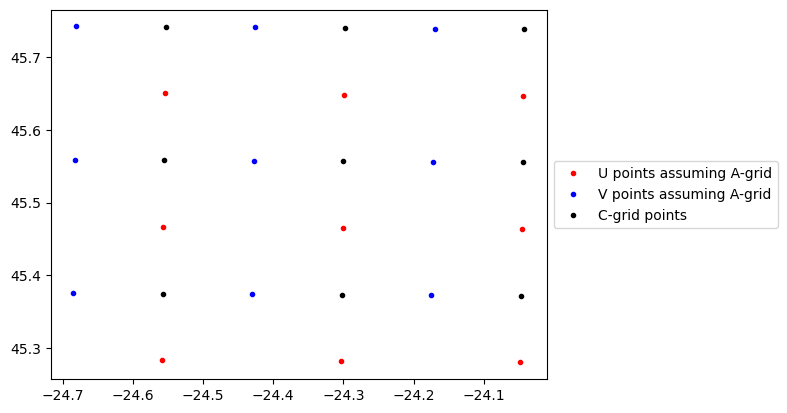

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa

fig, ax = plt.subplots()
nind = 3
ax1 = ax.plot(
    fieldsetA.U.grid.lon[:nind, :nind],
    fieldsetA.U.grid.lat[:nind, :nind],
    ".r",
    label="U points assuming A-grid",
)
ax2 = ax.plot(
    fieldsetA.V.grid.lon[:nind, :nind],
    fieldsetA.V.grid.lat[:nind, :nind],
    ".b",
    label="V points assuming A-grid",
)

ax3 = ax.plot(
    fieldsetC.U.grid.lon[:nind, :nind],
    fieldsetC.U.grid.lat[:nind, :nind],
    ".k",
    label="C-grid points",
)

ax.legend(handles=[ax1[0], ax2[0], ax3[0]], loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Further information about the NEMO C-grids is available in [the NEMO 3D tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_3D.html).


### Arakawa B-grids

Interpolation for Arakawa B-grids is detailed in [Section 2.1.3 of Delandmeter and Van Sebille (2019)](https://www.geosci-model-dev.net/12/3571/2019/gmd-12-3571-2019.html). Again, the dimensions that need to be provided are those of the barycentric cell edges `(i, j, k)`.

To load B-grid data, you can use the method `FieldSet.from_b_grid_dataset`, or specifically in the case of POP-model data `FieldSet.from_pop`.


## 3D C- and B-grids

For 3D C-grids and B-grids, the idea is the same. It is important to follow the indexing notation, which is defined in Parcels and in [Delandmeter and Van Sebille (2019)](https://www.geosci-model-dev.net/12/3571/2019/gmd-12-3571-2019.html). In 3D C-grids, the vertical (`W`) velocities are at the top and bottom. Note that in the vertical, the bottom velocity is often omitted, since a no-flux boundary conditions implies a zero vertical velocity at the ocean floor. That means that the vertical dimension of `W` often corresponds to the amount of vertical levels.
